# 1 Modeling Volatility and VaR

Use the returns on the S&P 500 $(r_M )$ and 1-month T-bills, (rf ) provided in “barnstable analysis data.xlsx”.

For the full sample of SPY returns, 1926-2023, calculate the LEVEL, (not log,) excess market returns (against the treasury returns.) We use this level excess return data throughout this section.+



In [1]:
import os
import pandas as pd
from scipy.stats import norm
import numpy as np
import matplotlib.pyplot as plt
from arch import arch_model
from arch.univariate import GARCH, EWMAVariance
import warnings
warnings.filterwarnings('ignore')
import_path = os.getcwd() + '/finm-portfolio-2022/'


rets = pd.read_excel('barnstable_analysis_data.xlsx', sheet_name=1)
rets.set_index('date', inplace=True)
rets.fillna(method='ffill', inplace=True)
rets['Excess SPY Returns'] = rets['SPX'] - rets['TB1M'] 
rets.head()

,SPX,TB1M,Excess SPY Returns
date,,,
1926-01-30,-0.001783,0.003061,-0.004844
1926-02-27,-0.033296,0.002612,-0.035908
1926-03-31,-0.057708,0.002601,-0.060309
1926-04-30,0.038522,0.002270,0.036252
1926-05-28,0.013623,0.002691,0.010932


### 1. Historic VaR.
Starting at t = 61, calculate the historic-based VaR, based on the expanding sample from period 1 (Jan 1926) to t − 1. By historic VaR, we mean simply taking the 5th quantile for the historic sample up to time t − 1. Of course, a sample size that is not a multiple of 100 will require some interpolation to get a 5th quantile. Your statistical package should handle this fine.

Denote this as $\tilde{r}^{VaR, 0.05}_{t,historic}$ which is the best estimate of the time-t VaR based on data through $t − 1$.

- Plot $\tilde{r}^{VaR, 0.05}_{t,historic}$ historic over time.


- Calculate the frequency of periods in which $\tilde{r} < \tilde{r}^{VaR, 0.05}_{t,historic}$


- What drawbacks do you see in this historic VaR?


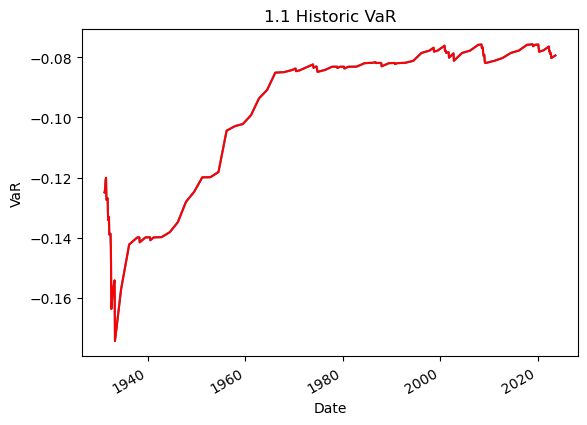

How many times returns has been lower than historical VaR 5%: 3.1%


In [8]:
historic_VaR = rets['Excess SPY Returns'].shift().expanding(min_periods = 60).quantile(.05)
historic_VaR.plot()
historic_VaR.plot(color='red') 

plt.title('1.1 Historic VaR')
plt.ylabel('VaR')
plt.xlabel('Date')
plt.show()

exceed = sum(rets['Excess SPY Returns'] < historic_VaR)/len(historic_VaR.dropna())
print('How many times returns has been lower than historical VaR 5%: {:,.1%}'.format(exceed))

<b> Drawbacks of Historic VaR </b>

1.  It relies completely on a particular historical dataset and its idiosyncrasies. For instance, if we run a Historical Simulations VaR in a bull market, VaR may be underestimated. Similarly, if we run a Historical Simulations VaR just after a crash, the falling returns which the portfolio has experienced recently may distort VaR. Also some events won´t be relevant again, but they are taken into account.

2.  It cannot capture changes in the market, so it is not a good predictor of the fucture. 


### 2. Volatility
We will calculate a time-series of volatility estimates using a few different methods. For each, we use σt to denote our estimate of the time-t return volatility, as based on data over periods 1 (Jan 1926) through $t − 1$, but not including $t$ itself.

- <b>Expanding Series$^1$</b>

$$
\sigma^2_{t,expanding} = \frac{1}{t-1}\sum_{\tau = 1}^{t-1}\tilde{r}^2_{\tau}
$$

Begin the calculation at t = 61, so that the first estimate is based on 60 data points.


- <b>Rolling Window</b>

$$
\sigma^2_{t,rolling} = \frac{1}{m}\sum_{l = 1}^{m}\tilde{r}^2_{t-l}
$$

Use m = 60, and begin the calculation at the t = 61, (so that the calculation has a full 60 data points.)


a) For each of these methods, plot $\sigma_t$. (Plot the vol, not the variance.)

b) For each method, calculate the 5th percentile, 1-month-ahead VaR. We use a slight simplification of the normal VaR formula, by dropping µ from that formula, and rounding the normal distribution z-score to -1.65.
$$\tilde{r}^{VaR, 0.05}_{t,vol} = −1.65 \sigma_t$$

c) For each of these vol-based VaR estimates, calculate the frequency of periods in which

$$
\tilde{r} < \tilde{r}^{VaR, 0.05}_{t,vol}
$$

d) Compare and contrast your results among each other and relative to the historic method in the previous problem.

In [16]:
stdev = np.sqrt((rets['Excess SPY Returns']**2).shift(1).expanding(60).mean().to_frame('Expanding Window'))
stdev['Rolling Window'] = np.sqrt((rets['Excess SPY Returns']**2).shift(1).rolling(60).mean())

## a)

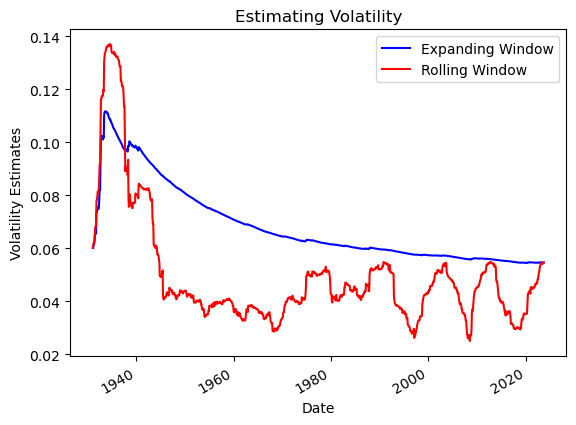

In [17]:

stdev['Expanding Window'].plot(color='blue', label='Expanding Window')
stdev['Rolling Window'].plot(color='red', label='Rolling Window')

plt.title('Estimating Volatility')
plt.ylabel('Volatility Estimates')
plt.xlabel('Date')
plt.legend()
plt.show()

Expanding Window method gives a more smoth volatily estimation, because includes more data

## b)

In [23]:
VaR = -1.65*stdev
VaR['Historic'] = historic_VaR


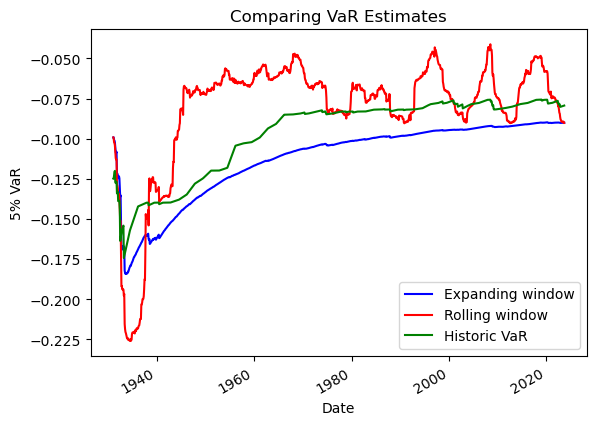

In [24]:
#specify series and colors
VaR['Expanding Window'].plot(color='blue', label='Expanding window')
VaR['Rolling Window'].plot(color='red', label='Rolling window')
VaR['Historic'].plot(color='green', label='Historic VaR')
plt.title('Comparing VaR Estimates')
plt.ylabel('5% VaR')
plt.xlabel('Date')
plt.legend()
plt.show()

## c)

In [26]:
freq_df = pd.DataFrame(index = ['Frequency'], columns = VaR.columns)

for col in freq_df:
    freq_df[col] = len(VaR[rets.loc[VaR.index, 'Excess SPY Returns'] < VaR[col]]) / len(VaR[col].dropna().index)
    
display(freq_df.style.format('{:,.2%}'))

,Expanding Window,Rolling Window,Historic
Frequency,1.80%,4.95%,3.15%


## d) 

The Expanding Window method has a lower frequency because it considers more data (so at some points it considers bear and bull market moments at the same time). 

Because Rolling window is based on the last 60 observations, it is more dependent on recent data at that point in time and therefore, in downturns or bear market moments, it more directly captures the worst returns.

### 3. CVaR
Re-do the previous two problems, but this time calculating CVaR instead of VaR, (still for
q = .05.) That is, calculate CVaR for

• the empirical cdf

• the normal model, using expanding volatility estimates 

• the normal model, using rolling volatility estimates

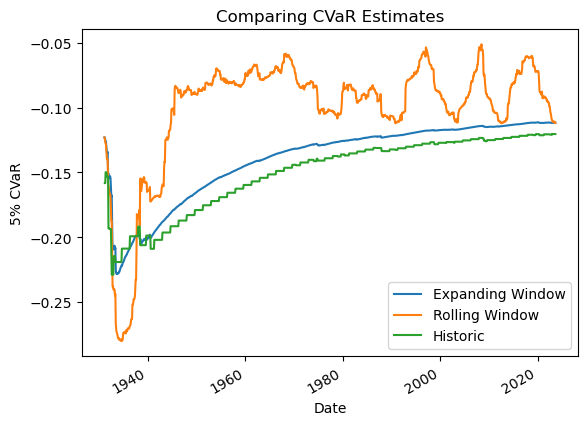

In [28]:
historic_CVaR = []

for i in range(len(rets)):
    if i < 61:
        historic_CVaR.append(np.nan)
    else:
        window = rets[['Excess SPY Returns']][:i-1]
        CVaR = window[window < window.quantile(0.05)]['Excess SPY Returns'].mean()
        historic_CVaR.append(CVaR)

scaling_for_vol = norm.pdf(1.65)/0.05 #trucated normal

CVaR = -scaling_for_vol * stdev

CVaR['Historic'] = historic_CVaR

CVaR.plot()
plt.title('Comparing CVaR Estimates')
plt.ylabel('5% CVaR')
plt.xlabel('Date')
plt.show()

### 4. Extra
We may discuss this after Midterm 1, but it is not part of the Midterm 1 material.

For the VaR calculations of Problem 2.2, and 2.3 try using the following models to estimate volatility:
- <b> Exponentially Weighted Moving Average (EWMA) </b>

    $$
    \sigma^2_{t, EWMA} = \theta \sigma^2_{t-1, EWMA} + (1-\theta)\tilde{r}^2_{t-1}
    $$

    Rather than estimating θ, simply use θ = 0.97, and initialize with σ1 = 0.15.



- <b> GARCH(1,1) model </b>
    To estimate GARCH(1,1), try using the ARCH package in Python. The default estimation implementation is fine. You should be familiar with EWMA and GARCH from the August Review.

In [29]:
GARCH = arch_model(rets['Excess SPY Returns'], vol='Garch', p=1, o=0, q=1, dist='Normal')
GARCH_model = GARCH.fit()
GARCH_model.params

Iteration:      1,   Func. Count:      6,   Neg. LLF: 47894645.18374588
Iteration:      2,   Func. Count:     16,   Neg. LLF: -1950.4634124805111
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1950.4634158658437
            Iterations: 6
            Function evaluations: 16
            Gradient evaluations: 2


mu          0.007870
omega       0.000059
alpha[1]    0.100000
beta[1]     0.879999
Name: params, dtype: float64

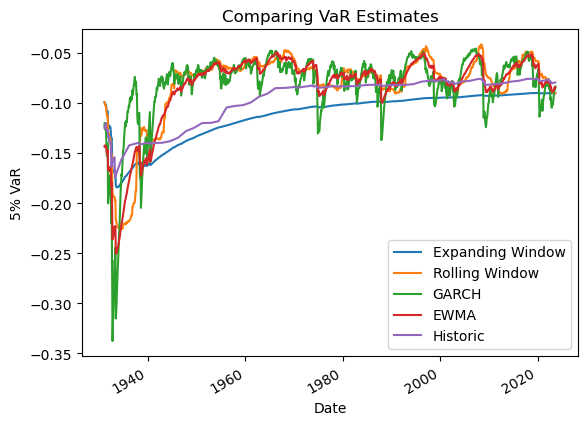

,Expanding Window,Rolling Window,GARCH,EWMA,Historic
Frequency,1.80%,4.95%,4.59%,4.32%,3.15%


In [30]:
stdev[['GARCH','EWMA']] = None

### Initialize with the given parameter
stdev.iloc[0,2:] = 0.15
theta = 0.97

### Simulate the rest of the period using the initial variance given
for i in range(1, len(stdev)):
    ### Forecast variance by plugging the GARCH and IGARCH parameters into their respective equations
    stdev['EWMA'].iloc[i] = np.sqrt((stdev['EWMA'].iloc[i-1]**2) * theta + (1-theta)*(rets[['Excess SPY Returns']].iloc[i-1,0]**2))
    stdev['GARCH'].iloc[i] = np.sqrt(GARCH_model.params['omega'] + (stdev['GARCH'].iloc[i-1]**2) * GARCH_model.params['beta[1]'] + GARCH_model.params['alpha[1]']*(rets[['Excess SPY Returns']].iloc[i-1,0]**2))
    
stdev.dropna(inplace=True)

VaR = -1.65*stdev
VaR['Historic'] = historic_VaR

VaR.plot()
plt.title('Comparing VaR Estimates')
plt.ylabel('5% VaR')
plt.xlabel('Date')
plt.show()

freq_df = pd.DataFrame(index = ['Frequency'], columns = VaR.columns)

for col in freq_df:
    freq_df[col] = len(VaR[rets.loc[VaR.index, 'Excess SPY Returns'] < VaR[col]]) / len(VaR[col].dropna().index)
    
display(freq_df.style.format('{:,.2%}'))

# 3. Estimating Underperformance

Use the returns on the S&P 500 $(r^M)$ and 1-month T-bills, $(r^f)$ provided in “barnstable analysis data.xlsx”.


Barnstable’s estimates of mean and volatility are based on the subsample of 1965 to 1999. We consider this subsample, as well as 2000-2022, as well as the full sample of 1926-2022. We only have data through August of 2022, but no adjustment is needed for the fact that you have only the partial year–just use what you have.

#### 1. Summary Statistics

(a) Report the following (annualized) statistics.

In [32]:
stats_table = pd.DataFrame(
            index = pd.MultiIndex.from_tuples([('levels', 'SPX'),('levels', 'RiskFree'),('levels', 'Excess SPX'),
                                              ('logs', 'SPX'),('logs', 'RiskFree'), ('logs', 'Excess SPX')]),
            columns = pd.MultiIndex.from_tuples([('1965-1999','mean'),('1965-1999','vol'),
                                                ('2000-2022','mean'),('2000-2022','vol'),
                                                ('1926-2022','mean'),('1926-2022','vol')]))

stats_table[('1965-1999','mean')] = list(np.mean(rets.loc['1965':'1999']) * 12) + list(np.mean(np.log(1+rets.loc['1965':'1999']))*12)
stats_table[('1965-1999','vol')] = list(np.std(rets.loc['1965':'1999']) * np.sqrt(12)) + list(np.std(np.log(1+rets.loc['1965':'1999'])) * np.sqrt(12))
stats_table[('2000-2022','mean')] = list(np.mean(rets.loc['2000':'2022']) * 12) + list(np.mean(np.log(1+rets.loc['2000':'2022']))*12)
stats_table[('2000-2022','vol')] = list(np.std(rets.loc['2000':'2022']) * np.sqrt(12)) + list(np.std(np.log(1+rets.loc['2000':'2022'])) * np.sqrt(12))
stats_table[('1926-2022','mean')] = list(np.mean(rets) * 12) + list(np.mean(np.log(1+rets))*12)
stats_table[('1926-2022','vol')] = list(np.std(rets) * np.sqrt(12)) + list(np.std(np.log(1+rets)) * np.sqrt(12))

display(stats_table.style.format('{:,.1%}'))

(b) Comment on how the full-sample return stats compare to the sub-sample stats. Comment on how the level stats compare to the log stats.

* Full sample Excess SPX estimates are bigger than the sub sample because they capture opposite behaviors at different points in time: low risk-free rate from 2000-2022 and very high SPX from 1965-1999.

* The difference between the full-sample vs the sub-sample stats is lower for log stats, probably because the log functions smooth the data

#### 2. Recall the following...

- If $x ∼ \mathcal{N}(\mu_x, \sigma^2_x)$, then
    $$
    Pr [x < l] = \Phi_\mathcal{N} (L)
    $$

    $$
    L = \frac{c − \mu_x}{\sigma_x}
    $$


  where $\Phi_{\mathcal{N}}$ denotes the standard normal cdf.



- Remember that cumulative log returns are simply the sum of the single-period log returns,

$$
𝚛^M_{t,t+h} = \sum^h_{i=1}𝚛^M_{t+i}
$$

- It will be convenient to use and denote sample averages. We use the following notation for an h-period average ending at time t + h


$$
\bar{𝚛}^M_{t,t+h} = \frac{1}{h} \sum^h_{i=1}𝚛^M_{t+i}
$$


Calculate the probability that the cumulative market return will fall short of the cumulative risk-free return.

$$Pr[R^M_{t,t+h} < R^f_{t,t+h}]$$ <div style="text-align: right"> (1)</div> 


To analyze this analytically, convert the probability statement above to a probability statement
about mean log returns.



(a) Calculate (1) using the subsample 1965-1999.



(b) Report the precise probability for h = 15 and h = 30 years.



(c) Plot the probability as a function of the investment horizon, h, for 0 < h ≤ 30 years.

In [41]:
def prob(mu, sigma, h):
    return norm.cdf(-np.sqrt(h)*mu/sigma)

mu = stats_table[('1965-1999', 'mean')][('logs', 'Excess SPX')]
sigma = stats_table[('1965-1999', 'vol')][('logs', 'Excess SPX')]

print('Probability of SPX underperforming RF in the next 15 years after 1999: {:,.1%}'.
      format(prob(mu = mu, sigma = sigma, h = 15)))

print('Probability of SPX underperforming RF in the next 30 years after 1999: {:,.1%}'.
      format(prob(mu = mu, sigma = sigma, h = 30)))

Probability of SPX underperforming RF in the next 15 years after 1999: 7.4%
Probability of SPX underperforming RF in the next 30 years after 1999: 2.0%


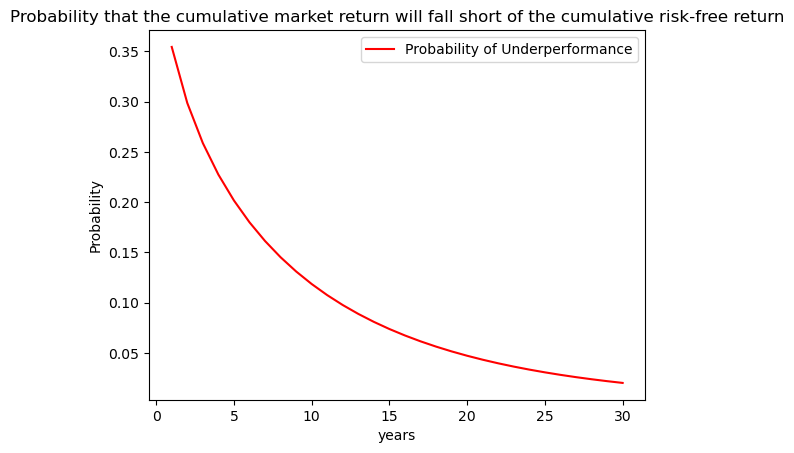

In [42]:
h = list(range(1, 31))
probs = pd.DataFrame([prob(mu, sigma, x) for x in h], columns=['Probability of Underperformance'], index = h)
probs.plot(color = 'red')
plt.title('Probability that the cumulative market return will fall short of the cumulative risk-free return')
plt.ylabel('Probability')
plt.xlabel('years')
plt.show()

#### 3. Use the sample 1965-2022 to reconsider the 30-year probability. As of the end of 2022, calculate the probability of the stock return underperforming the risk-free rate over the next 30 years. That is, $R^M_{t,t+h}$ underperforming $R^f_{t,t+h}$ for 0 < h ≤ 30.

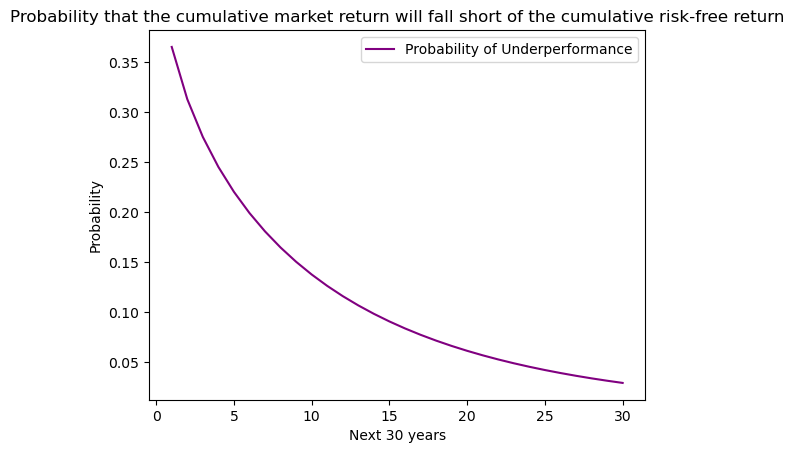

In [45]:
mu = np.log(1+rets['Excess SPY Returns'].loc['1965':'2022']).mean() * 12
sigma = np.log(1+rets['Excess SPY Returns'].loc['1965':'2022']).std() * np.sqrt(12)
h = list(range(1, 31))

probs = pd.DataFrame([prob(mu, sigma, x) for x in h], columns=['Probability of Underperformance'], index = h)
probs.plot(color = 'purple')
plt.title('Probability that the cumulative market return will fall short of the cumulative risk-free return')
plt.ylabel('Probability')
plt.xlabel('Next 30 years')
plt.show()

#### 4. Let’s consider how things turned out relative to Barnstable’s 1999 expectations.

(a) What was the probability (based on the 1999 estimate of $\mu$,) that the 23-year market return, $R^M_{t,t+23}$, would be smaller than that realized in 2000-2022? Note that we are asking about the market return, not the excess market return. Continue using the 1965-1999 sample standard deviation for $\sigma$.


In [46]:
mu = stats_table[('1965-1999', 'mean')][('logs', 'SPX')] - stats_table[('2000-2022', 'mean')][('logs', 'SPX')]
sigma = stats_table[('1965-1999', 'vol')][('logs', 'SPX')]

print('Probability of SPX underperforming in the next 23 years after 1999: {:,.2%}'.
      format(prob(mu = mu, sigma = sigma, h = 23)))

Probability of SPX underperforming in the next 23 years after 1999: 3.70%


(b) Suppose Barnstable had implemented the put-option strategy with the growing strike of 6%? Based on the 2000-2022 performance, what is the probability that the 2000-2029 cumulative market return will be low enough to make the puts in the money? For the calculation, update your estimates of $\mu$, $\sigma$ to be the estimates based on 1965-2022.

In [47]:
strike = np.log(1.06)

mean_return = np.log(1+rets['SPX'].loc['1965':]).mean() * 12

sigma = np.log(1 + rets['SPX'].loc['1965':]).std() * np.sqrt(12)

performance = np.log(1+rets['SPX'].loc['2000':]).mean() * 12

mu = ((23/7) * (performance - strike)) - (mean_return - strike)

print('Probability of Puts ending in the money: {:,.2%}'.
      format(prob(mu, sigma, 7)))

Probability of Puts ending in the money: 55.94%
